# Installation

In [4]:
!sudo apt-get install tesseract-ocr libtesseract-dev
!pip install pytesseract 'git+https://github.com/facebookresearch/detectron2.git' sentencepiece python-docx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr
  tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 29 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:5 http://archive.ubunt

In [5]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# LayoutLMv3

In [ ]:
from transformers import LayoutLMv3Processor, LayoutLMv3ForQuestionAnswering
from PIL import Image
import torch

# Load the fine-tuned model
# model = LayoutLMv3ForQuestionAnswering.from_pretrained("microsoft/layoutlmv3-base")
# # Load the tokenizer and feature extractor
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
# # Prepare the data
# image_path = "/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png"
# question = "What is the Serial No./ID of the Given Circular?"
# image = Image.open(image_path)


def layoutlmv3(model, processor, question, image):
    encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Perform inference
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the answer
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()
    if start_index<end_index:
      answer = encoding["input_ids"][0][start_index : end_index + 1]
      answer = processor.decode(answer)
    else:
      answer = encoding["input_ids"][0][end_index : start_index + 1]
      answer = processor.decode(answer)

    print(f"Answer: {answer}")
    return answer


#Donut

In [ ]:
!pip install sentencepiece

In [ ]:
from PIL import Image
question = "What is the Serial No./ID of the Given Circular?"
image = Image.open('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png').convert("RGB")
print(question)

What is the Serial No./ID of the Given Circular?


In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import re

# processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
# model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

def donut(model, processor, question, image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    task_prompt = "{user_input}"
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(pixel_values.to(device),
                                  decoder_input_ids=decoder_input_ids.to(device),
                                  max_length=model.decoder.config.max_position_embeddings,
                                  early_stopping=True,
                                  pad_token_id=processor.tokenizer.pad_token_id,
                                  eos_token_id=processor.tokenizer.eos_token_id,
                                  use_cache=True,
                                  num_beams=1,
                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                  return_dict_in_generate=True,
                                  output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    return seq

# Final Code

## Unitilites

In [48]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

In [49]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import re
from PIL import Image
from transformers import AutoModelForQuestionAnswering
from transformers import LayoutLMv2Processor
import pytesseract
import os
import json
import warnings
from transformers import LayoutLMv3Processor, LayoutLMv3ForQuestionAnswering
from docx import Document
from docx.shared import Inches
warnings.filterwarnings('ignore')

In [50]:
q_map={
    'q1':"Which organization issued this given circular?",
    'q2': "What is the Address of the Issuing Authority of the given Circular?",
    'q3': "What is the Serial No./ID of the Given Circular?",
    'q4': "What is the Date of Issuance of the Circular?",
    'q5': "What is the Subject of the given Circular?",
    'q6': "Who has this circular been addressed to?",
    'q7': "To Whom has the circular been forwarded to?",
    'q8': "Who Has Forwarded This Circular?",
    'q9': "What is the Designation of the Person who Forwarded this Circular?",
    'q10': "Who has signed the Given Circular?",
    'q11': "What is the Designation of the Person who Signed this Circular?"
}

def donut(model, processor, question, image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    task_prompt = "{user_input}"
    prompt = task_prompt.replace("{user_input}", question)
    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(pixel_values.to(device),
                                  decoder_input_ids=decoder_input_ids.to(device),
                                  max_length=model.decoder.config.max_position_embeddings,
                                  early_stopping=True,
                                  pad_token_id=processor.tokenizer.pad_token_id,
                                  eos_token_id=processor.tokenizer.eos_token_id,
                                  use_cache=True,
                                  num_beams=1,
                                  bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                  return_dict_in_generate=True,
                                  output_scores=True)
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    return seq

def layoutlmv2(model,processor,question,image):
    encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True, max_length=512)
    for k,v in encoding.items():
        encoding[k] = v.to(model.device)

    # Perform inference
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the answer
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    if start_index<end_index:
      answer = encoding["input_ids"][0][start_index : end_index + 1]
      answer = processor.decode(answer)
    else:
      answer = encoding["input_ids"][0][end_index : start_index + 1]
      answer = processor.decode(answer)

    return answer


def layoutlmv3(model, processor, question, image):
    encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True, max_length=512)
    for k,v in encoding.items():
        encoding[k] = v.to(model.device)

    # Perform inference
    outputs = model(**encoding)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the answer
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    if start_index<end_index:
      answer = encoding["input_ids"][0][start_index : end_index + 1]
      answer = processor.decode(answer)
    else:
      answer = encoding["input_ids"][0][end_index : start_index + 1]
      answer = processor.decode(answer)

    return answer

## Rough

To Whom has the circular been forwarded to?


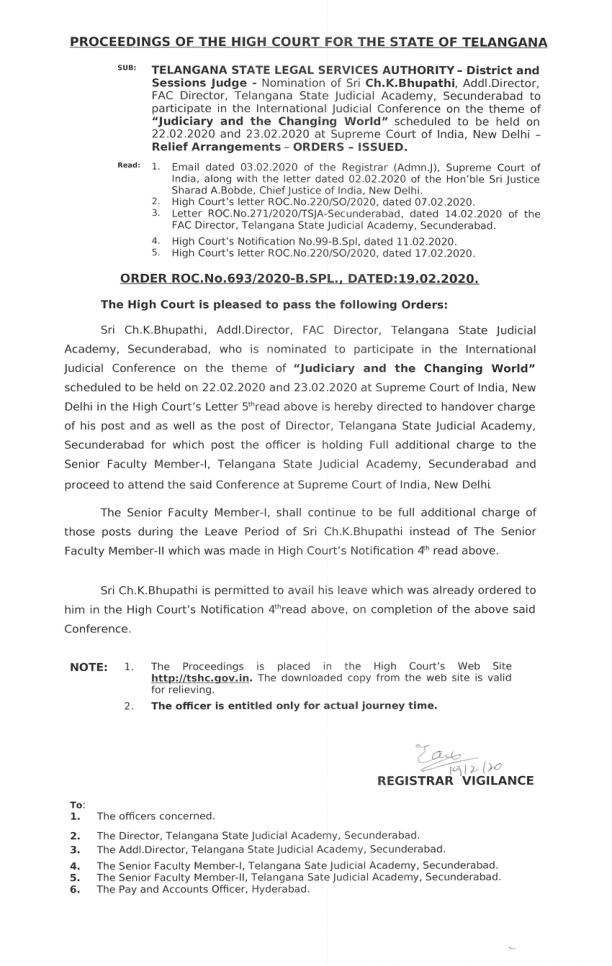

In [51]:
question = "To Whom has the circular been forwarded to?"
image = Image.open('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png').convert("RGB")
print(question)
image

In [53]:
model = AutoModelForQuestionAnswering.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
image = Image.open('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png').convert("RGB")
question = "To Whom has the circular been forwarded to?"
encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True, max_length=512)

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['layoutlmv2.visual_segment_embedding', 'qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [56]:
processor.decode(encoding['input_ids'][0])

"[CLS] to whom has the circular been forwarded to? [SEP] proceedings of the high court for the state of telangana sus telangana state legal services authority - district and sessions judge - nomination of sri ch. k. bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad to patticipate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india, new delhi - relief arrangements - orders - issued. feed : 1. email dated 03. 02. 2020 of the registrar ( admn, ), supreme court of india, along with the letter dated 02. 02. 2020 of the hon'ble sr justice sharad a. bobde, chief justice of india, new delhi 2. high courts letter roc. no. 220 / s0 / 2020, dated 07. 02. 2020. 3. letter roc. no. 271 / 2020 / ts ) a - secunderabad, dated 14. 02. 2020 of the fac director, telangana state judicial academy, secunderabad. 4. high court's notification no. 99 - 6.

## Main

In [52]:
import json
with open('/content/drive/MyDrive/tactful/docvqa.json','r') as f:
  data=json.load(f)
# data[0]

In [14]:
img_dir='/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/'# def infer(img_dir,data):
i=0
doc=Document()
for da in data:
    if i==5:
      break
    img_name=da['file_name']
    doc.add_heading(img_name, 1)
    img_path=os.path.join(img_dir,img_name)
    doc.add_picture(img_path,width=Inches(3)).alignment=1
    annotations=da['annotations']
    for annotation in annotations:
        if annotation['type']=='textarea':
            image = Image.open(img_path).convert("RGB")
            model_l2 = AutoModelForQuestionAnswering.from_pretrained("microsoft/layoutlmv2-base-uncased")
            processor_l2 = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
            model_l3= LayoutLMv3ForQuestionAnswering.from_pretrained("microsoft/layoutlmv3-base")
            processor_l3= LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
            model_do= VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
            processor_do= DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
            value=annotation['value']['text'][0]
            q=q_map[annotation['to_name']]
            l2=layoutlmv2(model_l2,processor_l2,q,image)
            l3=layoutlmv3(model_l3,processor_l3,q,image)
            do=''
            do=donut(model_do,processor_do,q,image).split('?')[1]
            p=doc.add_paragraph(f'Question : {q}\n >>>Orignial Answer : {value} \n >>>LayoutLMv2 : {l2}\n >>>LayoutLMv3 : {l3} \n >>>Donut : {do} \n')
            print('>>>')
            print('Question :',q)
            print('ORIGINAL :',value)
            print('LAYOUTLMV2 :',l2)
            print('LAYOUTLMV3 :',l3)
            print('DONUT :',do)
    i+=1
doc.save('demo.docx')


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Address of the Issuing Authority of the given Circular?
ORIGINAL : TELANGANA
LAYOUTLMV2 : proceedings of the high court for the state of telangana sus telangana state legal services authority - district and sessions judge - nomination of sri ch. k. bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad to patticipate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india, new delhi - relief arrangements - orders - issued. feed : 1. email dated 03. 02. 2020 of the registrar ( admn, ), supreme court of india, along with the letter dated 02. 02. 2020 of the hon'ble sr justice sharad a. bobde, chief justice of india, new delhi 2. high courts letter roc. no. 220 / s0 / 2020, dated 07. 02. 2020. 3. letter roc. no. 271 / 2020 / ts ) a - secunderabad, dated 14. 02. 2020 of the fac director, telangana state judicial aca

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Date of Issuance of the Circular?
ORIGINAL : 19-02-2020
LAYOUTLMV2 : judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india, new delhi - relief arrangements - orders - issued
LAYOUTLMV3 :  5. High Court's letter ROC.No.220/S0/2020, dated 17.02.2020. ORDER ROC.No.693/2020-B,SPL., DATED:19.02.2020, The High Court is pleased to pass the following Orders: Sri Ch.K.Bhupathi, Addl.Director, FAC Director, Telangana State Judicial Academy, Secunderabad, who is nominated to participate in the International Judicial Conference on the theme of “Judiciary and the Changing World” scheduled to be held on 22.02.2020 and 23.02.2020 at Supreme Court of india, New Delhi in the High Court's Letter read above is hereby directed to handover charge of his post and as well as the post of Director, Telangana State Judicial Academy, Secunderabad for which post the officer is holding Full additional charge to the Senior Facul

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Which organization issued this given circular?
ORIGINAL : PROCEEDINGS OF THE HIGH COURT FOR THE STATE OF TELANGANA
LAYOUTLMV2 : 02. 02. 2020 of the hon'ble sr justice sharad a. bobde, chief justice of india, new delhi 2. high courts letter roc. no. 220 / s0 / 2020, dated 07. 02. 2020. 3. letter roc. no. 271 / 2020 / ts ) a - secunderabad, dated 14. 02. 2020 of the fac director, telangana state judicial academy, secunderabad. 4. high court's notification no. 99 - 6. spl, dated 11. 02. 2020. 5. high court's letter roc. no. 220 / s0 / 2020, dated 17. 02. 2020. order roc. no. 693 / 2020 - b, spl., dated : 19. 02. 2020, the high court is pleased to pass the following orders : sri ch. k. bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad, who is nominated to participate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india,

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Serial No./ID of the Given Circular?
ORIGINAL : 693/2020-B.SPL
LAYOUTLMV2 : court of india, new delhi in the high court's letter read above is hereby directed to handover charge of his post and as well as the post of director, telangana state judicial academy, secunderabad for which post the officer is holding full additional charge to the
LAYOUTLMV3 :  the officer is holding Full additional charge to the Senior Faculty Member-I, Telangana State Judicial Academy, Secunderabad and proceed to attend the said Conference at Supreme Court of India, New Delhi The Senior Faculty Member-|, shall continue to be
DONUT :  Read: 1. Email dated 03.02.20.of the the the the the State LEGAL. Read: Read: 1. Email dated. of State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State State

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Subject of the given Circular?
ORIGINAL : TELANGANA STATE LEGAL SERVICES AUTHORITY - District and
Sessions Judge Nomination of Sri Ch.K.Bhupathi, Addl.Director, FAC Director, Telangana State Judicial Academy. Secunderabad to participate in the International Judicial Conference on the theme of "Judiciary and the Changing World" scheduled to be held on 22.02.2020 and 23.02.2020 at Supreme Court of India, New Delhi - Relief Arrangements ORDERS ISSUED.
LAYOUTLMV2 : 693 / 2020 - b, spl., dated : 19. 02. 2020, the high court is pleased to pass the following orders : sri ch. k. bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad, who is nominated to participate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india, new delhi in the high court's letter read above is
LAYOUTLMV3 :  Hon'ble Sr Justice Sharad A.Bobde, 

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Who has this circular been addressed to?
ORIGINAL : 1. The officers concerned.
2. The Director, Telangana State Judicial Academy, Secunderabad.
3. The Addl. Director, Telangana State Judicial Academy, Secunderabad.
4.
The Senior Faculty Member-1, Telangana Sate Judicial Academy, Secunderabad.
5. The Senior Faculty Member-II, Telangana Sate Judicial Academy, Secunderabad.
6. The Pay and Accounts Officer, Hyderabad.
LAYOUTLMV2 : bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad, who is nominated to participate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02. 2020 and 23. 02. 2020 at supreme court of india, new delhi in the high court's letter read above is hereby directed to handover charge of his post and as well as the post of director, telangana state judicial academy, secunderabad for which post the officer is holding full additional charge to the senior fa

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Designation of the Person who Signed this Circular?
ORIGINAL : REGISTRAR VIGILANCE
LAYOUTLMV2 : - district and sessions judge - nomination of sri ch. k. bhupathi, addl. director, fac director, telangana state judicial academy, secunderabad to patticipate in the international judicial conference on the theme of “ judiciary and the changing world ” scheduled to be held on 22. 02.
LAYOUTLMV3 :  2. High Courts letter ROC.No.220/S0/2020, dated 07.02.2020. 3. Letter ROC.No.271/2020/TS)A-Secunderabad, dated 14.02.2020 of the FAC Director, Telangana State Judicial Academy, Secunderabad. 4. High Court's Notification No.99
DONUT :  Read Read: 1. Email dated 03.03.03.()()()()()()()()()()()()()()()()()()()()()()()() Read: Read: Read Read: Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read Read R

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Date of Issuance of the Circular?
ORIGINAL : 30-04-2013
LAYOUTLMV2 : issuance of the circular? [SEP] pilidlliliettled we no, 5. 21011 / s8 / 2010 - 14 - 1 _ government of india ministry of environment and forests paryavaran bhawan cgo complex, udi oad ‘ new delhi - 110 003, dated : | apsil 30, 2013 office memorandum consideration of proposals from ratnagiri and sindty maharashtra. rq distriets, ‘ this has reference to the ministry's office memorandum of even no. dated 16 " august, 2010 and its subsequent amendments ineluding amendment issued on 28 ” march 2013 extension of moratorium upto 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhudurg, maharashtra under the ela notification, 2006 by this ministry or by the maharashtra state environment impact assessment authority ( sfiaa ). ‘ the ministry had constituted a high level working, grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide of

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Which organization issued this given circular?
ORIGINAL : Government of India Ministry of Environment and Forests
LAYOUTLMV2 : , grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide office order dated 17. 8 9012, to inter alia examine the western ghats feology expert panel report in a holistic and " multidisciplinary fashion keeping in view the comments received from the concerned state governments / central ministriesstakeholders. the working group has since submitted it report to the ministry which is under examination. keeping in view the above and in continuation of the om of 28 ” march, 2013, the ‘ moratorium. for
LAYOUTLMV3 :  Office Memorandum of even No. dated 16" August, 2010 and its subsequent amendments ineluding amendment issued on 28” March 2013 extension of moratorium upto 30” April, 2013
DONUT :  Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party Party P

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Address of the Issuing Authority of the given Circular?
ORIGINAL : New Delhi
LAYOUTLMV2 : reference to the ministry's office memorandum of even no. dated 16 " august, 2010 and its subsequent amendments ineluding amendment issued on 28 ” march 2013 extension of moratorium upto 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhudurg, maharashtra under the ela notification, 2006 by this ministry or by the maharashtra state environment impact assessment authority ( sfiaa ). ‘ the ministry had constituted a high level working, grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide office order dated 17. 8 9012, to inter alia examine the western ghats feology expert panel report in a holistic and " multidisciplin
LAYOUTLMV3 :  28” March, 2013, the ‘moratorium. for, consideration of projects from Sindhudurg and Ratnagin districts, laharashira is further extended upto 31 July, 2013, ‘This issues wit

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Serial No./ID of the Given Circular?
ORIGINAL : No. J.21011/58/2010-1A-1
LAYOUTLMV2 : ##yavaran bhawan cgo complex, udi oad ‘ new delhi - 110 003, dated : | apsil 30, 2013 office memorandum consideration of proposals from ratnagiri and sindty maharashtra. rq distriets, ‘ this has reference to the ministry's office memorandum of even no. dated 16 " august, 2010 and its subsequent amendments ineluding amendment issued on 28 ” march 2013 extension of moratorium upto 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhud
LAYOUTLMV3 :  April, 2013 on consideration of projects from the istriets of Ratnagiri and Sindhudurg, Maharashtra under the ELA Notification, 2006 by this Ministry or by the Maharashtra State Environment Impact Assessment Authority (SFIAA). ‘The Ministry had constituted a High Level Working, Grovp under the Chairmanship of Dr. K, Kast
DONUT : 


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Subject of the given Circular?
ORIGINAL : Consideration of proposals from Ratnagiri and Sindhudurg districts, Maharashtra.
LAYOUTLMV2 : office memorandum of even no. dated 16 " august, 2010 and its subsequent amendments ineluding amendment issued on 28 ” march 2013 extension of moratorium upto 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhudurg, maharashtra under the ela notification, 2006 by this ministry or by the maharashtra state environment impact assessment authority ( sfiaa ). ‘ the ministry had constituted a high level working, grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide office order dated 17. 8 9012, to inter alia examine the western ghats feology expert panel report in a holistic and " multidisciplinary fashion keeping in view the comments received from the concerned state governments / central ministriesstakeholders. the working group has since submitted
LAYOUTLMV3 

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Who has this circular been addressed to?
ORIGINAL : The Chairman, Maharashtra Pollution Control Board/Maharashtra, SELAA/SEAC
LAYOUTLMV2 : of even no. dated 16 " august, 2010 and its subsequent amendments ineluding amendment issued on 28 ” march 2013 extension of moratorium upto 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhudurg, maharashtra under the ela notification, 2006 by this ministry or by the maharashtra state environment impact assessment authority ( sfiaa ). ‘ the ministry had constituted a high level working, grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide office order dated 17. 8 9012, to inter alia examine the western ghats feology expert panel report in a holistic and " multidisciplinary fashion keeping in view the comments received from the concerned state governments / central ministriesstakeholders. the working group has since submitted it report to the ministry which is und

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : To Whom has the circular been forwarded to?
ORIGINAL : PS to MEF/PPS to Secretary (EAF)/MoFF Website/ Member Secretaries of sector specifie Expert Appraisal Committees and Officers of IA Division Guard File
LAYOUTLMV2 : keeping in view the above and in continuation of the om of 28 ” march, 2013, the ‘ moratorium. for, consideration of projects from sindhudurg and ratnagin districts, laharashira is further extended upto 31 july, 2013, ‘ this issues withthe approval of the competent authority director ahi, chairman, maharashtra pollution control roard / maharashira, selaa
LAYOUTLMV3 :  view the above and in continuation of the OM of 28” March, 2013, the ‘moratorium. for, consideration of projects from Sindhudurg and Ratnagin districts, laharashira is further extended upto 31 July, 2013, ‘This issues withthe approval of the Competent Authority Director AHI, Chairman, Maharashtra Pollution Control Roard/Maharashira, SELAA/SFAC PS to MEFVPPS to Sectetary(EAF)/MoEF Website/ Me

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Who has signed the Given Circular?
ORIGINAL : Lant Kapur
LAYOUTLMV2 : 30 ” april, 2013 on consideration of projects from the istriets of ratnagiri and sindhudurg, maharashtra under the ela notification, 2006 by this ministry or by the maharashtra state environment impact assessment authority ( sfiaa ). ‘ the ministry had constituted a high level working, grovp under the chairmanship of dr. k, kasturirangan, member, planning commission, vide office order dated 17. 8 9012, to inter alia examine the western ghats feology expert panel report in a holistic and " multidisciplinary fashion keeping in view the comments received from the concerned state governments / central ministriesstakeholders. the working group has since submitted it report to the ministry which is under examination. keeping in view the above and in continuation of the om of 28 ” march, 2013, the ‘ moratorium. for, consideration of projects from sindhudurg and ratnagin districts, laharashira is further exten

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Designation of the Person who Signed this Circular?
ORIGINAL :  Director(IA-II)
LAYOUTLMV2 : / 2010 - 14 - 1 _ government of india ministry of environment and forests paryavaran bhawan cgo complex, udi oad ‘ new delhi - 110 003, dated : | ap
LAYOUTLMV3 : iri and Sindhudurg, Maharashtra under the ELA Notification, 2006 by this Ministry or by the Maharashtra State Environment Impact Assessment Authority (SFIAA). ‘The Ministry had constituted a High Level Working, Grovp under the Chairmanship of Dr. K, Kasturirangan, Member, Planning Commission, vide office order dated 17.8 9012, to inter alia examine the Western Ghats Feology Expert Panel Report in a holistic and "multidisciplinary fashion keeping in view the comments received from the concerned State Governments/Central MinistriesStakeholders. The working Group has since submitted it report to the Ministry which is under examination. Keeping in view the above and in continuation of the OM of 28” March, 2013, t

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Address of the Issuing Authority of the given Circular?
ORIGINAL : The Gazette of India
LAYOUTLMV2 : aa et at server he ft, fe ft afin rae be tte er fe at, sire a crore ay aft ra a 6 ster, 2002 at are et a te sire fe arene grey ser re pet ava aera
LAYOUTLMV3 :  ATA 6 sir, 2020 aver Parr Fy ae 3, Ft sa anit saat &, Fe sa sean a ater ot, a are, Fendt ser aie a sate ea art crores aa eT at server he ft, Fe ft afin rae Be tte er Fe aT, sire a crore AY aft ra a 6 ster, 2002 At are eT a TE sire fe arene grey ser re Pet ava aera are a afte eat oe frre fra mare: a, edie ar, sree ara fre 1988 (1988 a $9) Fr ener 110 art wee aa aT sri ac gu, edie tee ara Fras, 1989 rst ses er Fa FAP Fra aT &, a 4.(1) 3 i ar fir ar edt iter ara (regain Fre, 2022 & 1 (Q) tas sa sre A arte a ET aT</s>
DONUT : 


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Serial No./ID of the Given Circular?
ORIGINAL : NEW DELHI
LAYOUTLMV2 : 2022 / shravana 27, 1944 sae ofeage she cone stare afar 8 fect,
LAYOUTLMV3 : .(1) 3 i ar fir ar edt iter ara (regain Fre, 2022 & 1 (
DONUT : 


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Date of Issuance of the Circular?
ORIGINAL : 18 अगस्त, 2022
LAYOUTLMV2 : ater ot, a are, fendt ser aie a sate ea art crores aa et at server he ft, fe ft afin rae be tte er fe at, sire a crore ay aft ra a 6 ster, 2002 at are et a te sire fe arene grey ser re pet ava aera are a afte eat oe frre fra
LAYOUTLMV3 :  are eT a TE sire fe arene grey ser re Pet ava aera are a afte eat oe frre fra mare: a, edie ar, sree ara fre 1988 (1988 a $9) Fr ener 110 art wee aa aT sri ac gu, edie tee ara Fras, 1989 rst ses er Fa FAP Fra aT &, a 4.(1) 3 i ar fir ar edt iter ara (regain Fre, 2022 & 1 (Q) tas sa sre A arte a
DONUT : .....................................................................................................................................................................................................................................................................................................................................................................

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Subject of the given Circular?
ORIGINAL : 566
LAYOUTLMV2 : ##s ( 9 fica re rare ae ofer ate ere re a spa area tatar. 27 ( 3 ), ata 6 sir, 2020 aver parr fy ae 3
LAYOUTLMV3 : RAVANA 27, 1944 sae ofeage she cone stare afar 8 fect, 18 se, 2022 ara, 640(59. site ae Pry, 1989 a se are ae Fe ree, tee a srfnfren, 1988 (1988 41 59) rarer 212 A seurer (1) 7 anf ear afer, Te TTT, ATTY, sar, ae 3, aes (9 fica re rare ae Ofer ate ere re A spa area TATAR. 27 (3), ATA 6 sir, 2020 aver Parr Fy ae 3, Ft sa anit saat &, Fe sa sean a ater ot, a are, Fendt ser aie a sate
DONUT : ......................................................................................................................................................................................................................................................................................................................................................................................................................

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Which organization issued this given circular?
ORIGINAL : DELHI STATE INDUSTRIAL & INFRASTRUCTURE DEVELOPMENT CORPORATION LIMITED
LAYOUTLMV2 : infrastructure development ‘ corporation limited the audit commitee recommended in their meets 29. 09. 2015 « hat the interusit ‘ ntraunit reconciliation of all the divisions with the hq & tmtraunit should be done within a one month's time of the sveounting year ending. hence all the divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on m, c. jain chief accounts officer 4 aonworks ) dsude cnoiguoe ) dsudc aor ) dshde all division heads dme ) for website
LAYOUTLMV3 :  one month's time of the sveounting year ending. Hence all the divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on M,C. Jain Chief Accounts Officer 4 AOnworks) DSUDE CNOiguoe) DSUDC AOR) DSHDE Al

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Date of Issuance of the Circular?
ORIGINAL : 07-12-2015
LAYOUTLMV2 : industrial & infrastructure development ‘ corporation limited the audit commitee recommended in their meets 29. 09. 2015 « hat the interusit ‘ ntraunit reconciliation of all the divisions with the hq & tmtraunit should be done within a one month's time of the sveounting year ending. hence all the divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on m, c. jain chief accounts officer 4 aonworks ) dsude cnoiguoe ) dsudc aor ) dshde all division heads dme ) for website caps
LAYOUTLMV3 :  their meets 29.09.2015 «hat the interusit ‘ntraunit reconciliation of all the divisions with the HQ & tmtraunit should be done within a one month's time of the sveounting year ending. Hence all the divisions heads are requested
DONUT :  TEL. TEL. TEL. TEL. TEL. TEL. SELECRETRETRETRETRETRETRETRETRETRETRETRETRETRETRETRETRETRETR

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Serial No./ID of the Given Circular?
ORIGINAL : DSIDOCOMMA/C 2015-16/
LAYOUTLMV2 : « hat the interusit ‘ ntraunit reconciliation of all the divisions with the hq & tmtraunit should be done within a one month's time of the sveounting year ending. hence all the divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from
LAYOUTLMV3 :  divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on M,C. Jain Chief Accounts Officer 4 AOnworks) DSUDE CNOiguoe) DSUDC AOR) DSHDE All Division Heads DME) for website Caps to } PA $0 DE for intonination Page aot</s>
DONUT : 


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Who has this circular been addressed to?
ORIGINAL : CAUrworks).DSHDC
CAOliquor) DSUDC
CAOIRL) DSTIDC
All Division Heads
DM(IT) for website
LAYOUTLMV2 : state industrial & infrastructure development ‘ corporation limited the audit commitee recommended in their meets 29. 09. 2015 « hat the interusit ‘ ntraunit reconciliation of all the divisions with the hq & tmtraunit should be done within a one month's time of the sveounting year ending. hence all the divisions heads are requested to get uheir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on m, c. jain chief
LAYOUTLMV3 : heir imerunit balances sevoncited quarterly atthe end of one month from the end of the quarter held on M,C. Jain Chief Accounts Officer 4 AOnworks) DSUDE CNOiguoe) DSUDC AOR) DSHDE All Division Heads DME) for website Caps to } PA $0 DE for intonination Page aot</s>
DONUT :  PELLOPMENT CORPORATION LIMITED TELLOPMENT TELLOPMENT TELLOPMENT TELLOPMENT TELLOPME

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : To Whom has the circular been forwarded to?
ORIGINAL : PA to DF for Information
LAYOUTLMV2 : $ 0 de for
LAYOUTLMV3 : SHDCCOMMAKE 2015-16 Dated: 07.12.2015 DELI STATE INDUSTRIAL & INFRASTRUCTURE DEVELOPMENT �
DONUT : 


Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : Who has signed the Given Circular?
ORIGINAL : M. C. Gain
LAYOUTLMV2 : aonworks ) dsude cnoiguoe ) dsudc aor ) dshde all division heads dme ) for website caps to } pa $ 0 de for into
LAYOUTLMV3 :  all the divisions with the HQ & tmtraunit should be done within a one month's time of the sveounting year ending. Hence
DONUT : .....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias', 'layoutlmv2.visual_segment_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


>>>
Question : What is the Designation of the Person who Signed this Circular?
ORIGINAL : Chief Accounts Officer
LAYOUTLMV2 : development ‘ corporation limited the audit commitee
LAYOUTLMV3 :  uw DSHDCCOMMAKE 2015-16 Dated: 07.12.2015 DELI STATE INDUSTRIAL & INFRASTRUCTURE DEVELOPMENT ‘CORPORATION LIMITED The Audit Commitee recommended in their meets 29.09.2015 «
DONUT : 


In [ ]:
infer('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/',data)

Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['qa_outputs.weight', 'layoutlmv2.visual_segment_embedding', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['qa_outputs.dense.weight', 'qa_outputs.out_proj.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

401 239


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


401 239


TypeError: BaseImageProcessor.__call__() takes 2 positional arguments but 3 were given

In [ ]:

doc=Document()
doc.add_heading('img_name', 1)
doc.add_picture('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png',width=Inches(3)).alignment=1
p=doc.add_paragraph('Question :\n >>>Orignial Answer :\n >>>LayoutLMv2 :\n >>>LayoutLMv3 :\n >>>Donut :\n')
doc.save('demo.docx')

# UDOP

In [ ]:
!pip install git+https://github.com/NielsRogge/transformers.git@add_udop sentencepiece

In [1]:
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Optional

import torch
import transformers
from PIL import Image
from transformers import HfArgumentParser, TrainingArguments, set_seed
from transformers.models.udop import UdopConfig,UdopForConditionalGeneration,UdopImageProcessor,UdopProcessor
from transformers.trainer_utils import get_last_checkpoint, is_main_process
from transformers.utils import check_min_version

In [2]:
import transformers.models.udop as udop

In [3]:
import torch
from PIL import Image
import spacy

tokenizer = udop.UdopTokenizer.from_pretrained("ArthurZ/udop")
config = udop.UdopConfig.from_pretrained("nielsr/udop-large")
model = udop.UdopModel(config)
image_processor = udop.UdopImageProcessor()
processor = udop.UdopProcessor(image_processor=image_processor, tokenizer=tokenizer)

image = Image.open('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png')
image = image.resize((224, 224))
question = 'To whom the letter is addressed'
encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True)

# Specify decoder_inputs or decoder_inputs_embeds
# You need to decide how you want to provide the decoder inputs based on your specific use case
# For example, you might want to use decoder_inputs_embeds with precomputed embeddings

# Example with random tensor for decoder_inputs_embeds
decoder_inputs_embeds = torch.rand((1, encoding['input_ids'].shape[1], model.config.hidden_size))

# Pass decoder_inputs_embeds to the model
outputs = model(**encoding, decoder_inputs_embeds=decoder_inputs_embeds)

# Extract the relevant tensor and then decode
output_tensor = outputs[0][0]  # Assuming the first tensor is the relevant one

decoded_output = tokenizer.decode(output_tensor.argmax(dim=-1), skip_special_tokens=True)

# Print or use the decoded output
print("Decoded Output:", decoded_output)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:980: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:934: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warn

Decoded Output: vala Ein story story Ein than


In [10]:
with open('hey.txt','w') as f:
  f.write(str(outputs))

In [62]:
processor.decode(outputs[0][0].argmax(dim=1))

'[unused919] [unused461] [unused746] * *'

In [60]:
index = outputs[0][0].argmax(dim=1)
index

tensor([ 924,  466,  751, 1008, 1008])

In [63]:
tokenizer.decode(index)

'less That won Don Don'

In [24]:
# m=udop.UdopModel(config)decoder_inputs_embeds = torch.rand((1, encoding['input_ids'].shape[1], m.config.hidden_size))
output=m(**encoding, decoder_inputs_embeds=decoder_inputs_embeds)
output_tensor = output[0][0]  # Assuming the first tensor is the relevant one
decoded_output = tokenizer.decode(output_tensor.argmax(dim=-1), skip_special_tokens=True)

# Print or use the decoded output
print("Decoded Output:", decoded_output)

In [55]:
# Get the model's output tensor
output_tensor = output[0]

# Select the token IDs with the highest values in the output tensor
generated_token_ids = torch.argmax(output_tensor, dim=-1)

# Use the tokenizer to decode the token IDs back into text
decoded_text = tokenizer.decode(generated_token_ids[0], skip_special_tokens=True)

print(decoded_text)


finalR] needcetteRR]]Rcette possibleRRR


In [27]:
tokenizer.decode(torch.argmax(outputs[0], dim=-1)[0])

'mai pe modern didntheque ouquezuH ou outhe ouar'

In [4]:
image_processor = UdopImageProcessor(
    size={"height": 224, "width": 224},
)
tokenizer = udop.UdopTokenizer.from_pretrained("ArthurZ/udop")
processor = UdopProcessor(image_processor=image_processor, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
image = Image.open('/content/drive/MyDrive/tactful/SplitCircularsv2/first_page/1056_bspl_2_2020_02_19_16_21_01_fp.png')
image = image.resize((224, 224))
question= 'What is the Serial No./ID of the Given Circular?'
encoding = processor(image, question, return_tensors="pt", padding=True, truncation=True)

In [7]:
import torch
from PIL import Image
import spacy

tokenizer = udop.UdopTokenizer.from_pretrained("ArthurZ/udop")
config = UdopConfig.from_pretrained("nielsr/udop-large")
model = UdopForConditionalGeneration.from_pretrained('nielsr/udop-large',config=config).to('cpu')
# processor = UdopProcessor(image_processor=image_processor, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
